# Install Packages

In [ ]:
pip install spacy scikit-learn pandas matplotlib sentence-transformers

In [ ]:
pip install scispacy bertopic umap-learn plotly

# A. 1. Import CSV Data

In [ ]:
import pandas as pd
from google.colab import files
import io

# 1) Upload a local CSV file
uploaded = files.upload()
fname = list(uploaded.keys())[0]
raw = uploaded[fname]

def load_texts_csv(raw_bytes):
    """Load a CSV file into a single-column DataFrame named 'text'.
       Handles header or no-header cases; cleans empty/duplicate rows."""
    try:
        # Try normal CSV with UTF-8 encoding
        df = pd.read_csv(io.BytesIO(raw_bytes), encoding='utf-8-sig')
        # If 'text' column not found or more than 1 column, fallback to single-column mode
        if 'text' not in df.columns or df.shape[1] != 1:
            df = pd.read_csv(io.BytesIO(raw_bytes), header=None, names=['text'], encoding='utf-8-sig')
    except Exception:
        # Fallback encoding (latin-1)
        df = pd.read_csv(io.BytesIO(raw_bytes), header=None, names=['text'], encoding='latin-1')

    # Clean data: drop empty / duplicate rows
    df['text'] = df['text'].astype(str).str.strip()
    df = df[df['text'].str.len() > 0].drop_duplicates().reset_index(drop=True)
    return df

# Load uploaded CSV
df = load_texts_csv(raw)
print(f"✅ Loaded {len(df)} rows, {len(df.columns)} column -> {df.columns.tolist()}")
df.head(3)

Saving texts.csv to texts (3).csv
✅ Loaded 70 rows, 1 column -> ['text']


,text
0,"The International Genomics of Alzheimer's Project (IGAP) is a consortium for characterizing the genetic landscape of Alzheimer's disease (AD). The identified and/or confirmed 19 single-nucleotide polymorphisms (SNPs) associated with AD are located on non-coding DNA regions, and their functional impacts on AD are as yet poorly understood. We evaluated the roles of the IGAP SNPs by integrating data from many resources, based on whether the IGAP SNP was (1) a proxy for a coding SNP or (2) associated with altered mRNA transcript levels. For (1), we confirmed that 12 AD-associated coding common SNPs and five nonsynonymous rare variants are in linkage disequilibrium with the IGAP SNPs. For (2), the IGAP SNPs in CELF1 and MS4A6A were associated with expression of their neighboring genes, MYBPC3 and MS4A6A, respectively, in blood. The IGAP SNP in DSG2 was an expression quantitative trait loci (eQTL) for DLGAP1 and NETO1 in the human frontal cortex. The IGAP SNPs in ABCA7, CD2AP, and CD33 each acted as eQTL for AD-associated genes in brain. Our approach for identifying proxies and examining eQTL highlighted potentially impactful, novel gene regulatory phenomena pertinent to the AD phenotype."
1,"Alzheimer's disease (AD) is a progressive neurodegenerative disorder caused by the interplay of multiple genetic and non-genetic factors. Hypertension is one of the AD risk factors that has been linked to underlying pathological changes like senile plaques and neurofibrillary tangles formation as well as hippocampal atrophy. In this study, we investigated the differences in the genetic architecture of AD between hypertensive and non-hypertensive subjects in four independent cohorts. Our genome-wide association analyses revealed significant associations of 15 novel potentially AD-associated polymorphisms (P < 5E-06) that were located outside the chromosome 19q13 region and were significant either in hypertensive or non-hypertensive groups. The closest genes to 14 polymorphisms were not associated with AD at P < 5E-06 in previous genome-wide association studies (GWAS). Also, four of them were located within two chromosomal regions (i.e., 3q13.11 and 17q21.2) that were not associated with AD at P < 5E-06 before. In addition, 30 genes demonstrated evidence of group-specific associations with AD at the false discovery rates (FDR) < 0.05 in our gene-based and transcriptome-wide association analyses. The chromosomal regions corresponding to four genes (i.e., 2p13.1, 9p13.3, 17q12, and 18q21.1) were not associated with AD at P < 5E-06 in previous GWAS. These genes may serve as a list of prioritized candidates for future functional studies. Our pathway-enrichment analyses revealed the associations of 11 non-group-specific and four group-specific pathways with AD at FDR < 0.05. These findings provided novel insights into the potential genetic heterogeneity of AD among subjects with and without hypertension."
2,"Alzheimer's disease (AD) is highly heritable and recent studies have identified over 20 disease-associated genomic loci. Yet these only explain a small proportion of the genetic variance, indicating that undiscovered loci remain. Here, we performed a large genome-wide association study of clinically diagnosed AD and AD-by-proxy (71,880 cases, 383,378 controls). AD-by-proxy, based on parental diagnoses, showed strong genetic correlation with AD (rg = 0.81). Meta-analysis identified 29 risk loci, implicating 215 potential causative genes. Associated genes are strongly expressed in immune-related tissues and cell types (spleen, liver, and microglia). Gene-set analyses indicate biological mechanisms involved in lipid-related processes and degradation of amyloid precursor proteins. We show strong genetic correlations with multiple health-related outcomes, and Mendelian randomization results suggest a protective effect of cognitive ability on AD risk. These results are a step forward in identifying the genetic factors that contribute to AD risk

# A. 2. Entity Extraction

In [ ]:
import pandas as pd
import re
import unicodedata

# === Step 1. Load and normalize text ===
df = pd.read_excel("text.xlsx", header=None, names=["text"])

ZERO_WIDTH = re.compile(r"[\u200B-\u200D\uFEFF]")
def normalize_text(s: str) -> str:
    """Clean invisible chars and normalize Unicode punctuation."""
    s = "" if pd.isna(s) else str(s)
    s = unicodedata.normalize("NFKC", s)
    s = ZERO_WIDTH.sub("", s)
    s = (s.replace("\u2019", "'").replace("\u2018", "'")
           .replace("\u201c", '"').replace("\u201d", '"'))
    return s.strip()

df["text"] = df["text"].map(normalize_text)

# === Step 2. Regex patterns for entity detection ===
VARIANT_RE = re.compile(r"(?i)rs[0-9]+")
GENE_RE    = re.compile(r"\b[A-Z]{2,}\b")

# --- Improved disease extraction ---
# Base regex: capture phrases ending with common disease suffixes
DISEASE_BASE = re.compile(
    r"\b([A-Z][a-z]+(?:\s+[A-Z][a-z]+)*\s+(Disease|Disorder|Syndrome|Dementia|Cancer|Diabetes|Infection|Condition|Deficiency))\b"
)

# Common disease keywords (for one-word diseases or partial phrases)
COMMON_DISEASE_KEYWORDS = [
    "Alzheimer", "Parkinson", "Dementia", "Diabetes", "Cancer", "Obesity",
    "Stroke", "Schizophrenia", "Hypertension", "Epilepsy", "Autism",
    "Depression", "Asthma", "Cardiomyopathy", "Atherosclerosis",
    "Tumor", "Leukemia", "Inflammation"
]

# Common false-positive phrases to exclude
EXCLUDE_PHRASES = [
    "Working Group", "Consortium", "Association", "Cohort", "Project",
    "Study", "Sample", "Analysis", "Institute", "Foundation",
    "Genomics", "Genetic", "Consortium", "Meta-Analysis"
]

def extract_diseases(text: str):
    """Hybrid rule-based disease extraction combining regex and keyword filters."""
    diseases = set()

    # --- (1) Regex matches based on suffix keywords ---
    for match in DISEASE_BASE.findall(text):
        diseases.add(match[0])

    # --- (2) Keyword-based detection for standalone names ---
    for kw in COMMON_DISEASE_KEYWORDS:
        pattern = re.compile(rf"\b{kw}\b", flags=re.IGNORECASE)
        if pattern.search(text):
            diseases.add(kw)

    # --- (3) Remove known false positives ---
    diseases = {d for d in diseases if not any(ex in d for ex in EXCLUDE_PHRASES)}

    return sorted(diseases)

# === Step 3. Apply entity extraction ===
def extract_entities(text):
    s = normalize_text(text)
    variants = sorted(set(VARIANT_RE.findall(s)))
    genes    = sorted(set(GENE_RE.findall(s)))
    diseases = extract_diseases(s)
    return pd.Series({"variants": variants, "genes": genes, "diseases": diseases})

out_df = pd.concat([df, df["text"].apply(extract_entities)], axis=1)

# === Step 4. Display and save ===
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 2000)
display(out_df)

out_df.to_csv("extracted_entities_full.csv", index=False, encoding="utf-8-sig")
print("✅ Saved improved entity extraction results to extracted_entities_full.csv")

,text,variants,genes,diseases
0,"The International Genomics of Alzheimer's Project (IGAP) is a consortium for characterizing the genetic landscape of Alzheimer's disease (AD). The identified and/or confirmed 19 single-nucleotide polymorphisms (SNPs) associated with AD are located on non-coding DNA regions, and their functional impacts on AD are as yet poorly understood. We evaluated the roles of the IGAP SNPs by integrating data from many resources, based on whether the IGAP SNP was (1) a proxy for a coding SNP or (2) associated with altered mRNA transcript levels. For (1), we confirmed that 12 AD-associated coding common SNPs and five nonsynonymous rare variants are in linkage disequilibrium with the IGAP SNPs. For (2), the IGAP SNPs in CELF1 and MS4A6A were associated with expression of their neighboring genes, MYBPC3 and MS4A6A, respectively, in blood. The IGAP SNP in DSG2 was an expression quantitative trait loci (eQTL) for DLGAP1 and NETO1 in the human frontal cortex. The IGAP SNPs in ABCA7, CD2AP, and CD33 each acted as eQTL for AD-associated genes in brain. Our approach for identifying proxies and examining eQTL highlighted potentially impactful, novel gene regulatory phenomena pertinent to the AD phenotype.",[],"[AD, DNA, IGAP, SNP]",[Alzheimer]
1,"Alzheimer's disease (AD) is a progressive neurodegenerative disorder caused by the interplay of multiple genetic and non-genetic factors. Hypertension is one of the AD risk factors that has been linked to underlying pathological changes like senile plaques and neurofibrillary tangles formation as well as hippocampal atrophy. In this study, we investigated the differences in the genetic architecture of AD between hypertensive and non-hypertensive subjects in four independent cohorts. Our genome-wide association analyses revealed significant associations of 15 novel potentially AD-associated polymorphisms (P < 5E-06) that were located outside the chromosome 19q13 region and were significant either in hypertensive or non-hypertensive groups. The closest genes to 14 polymorphisms were not associated with AD at P < 5E-06 in previous genome-wide association studies (GWAS). Also, four of them were located within two chromosomal regions (i.e., 3q13.11 and 17q21.2) that were not associated with AD at P < 5E-06 before. In addition, 30 genes demonstrated evidence of group-specific associations with AD at the false discovery rates (FDR) < 0.05 in our gene-based and transcriptome-wide association analyses. The chromosomal regions corresponding to four genes (i.e., 2p13.1, 9p13.3, 17q12, and 18q21.1) were not associated with AD at P < 5E-06 in previous GWAS. These genes may serve as a list of prioritized candidates for future functional studies. Our pathway-enrichment analyses revealed the associations of 11 non-group-specific and four group-specific pathways with AD at FDR < 0.05. These findings provided novel insights into the potential genetic heterogeneity of AD among subjects with and without hypertension.",[],"[AD, FDR, GWAS]","[Alzheimer, Hypertension]"
2,"Alzheimer's disease (AD) is highly heritable and recent studies have identified over 20 disease-associated genomic loci. Yet these only explain a small proportion of the genetic variance, indicating that undiscovered loci remain. Here, we performed a large genome-wide association study of clinically diagnosed AD and AD-by-proxy (71,880 cases, 383,378 controls). AD-by-proxy, based on parental diagnoses, showed strong genetic correlation with AD (rg = 0.81). Meta-analysis identified 29 risk loci, implicating 215 potential causative genes. Associated genes are strongly expressed in immune-related tissues and cell types (spleen, liver, and microglia). Gene-set analyses indicate biological mechanisms involved in lipid-related processes and degradation of amyloid precursor proteins. We show strong genetic correlations with multiple health-related outcomes, and Mendelian randomization results suggest a protective effect of cognitive abi

✅ Saved improved entity extraction results to extracted_entities_full.csv


# A. 3. Topic Modeling

In [ ]:
# ====================================================
# STEP 2️⃣  Build combined text (abstract + entities)
# ====================================================

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Read the entity extraction output
df = pd.read_csv("extracted_entities_full.csv")

# Combine raw text with extracted entities to enrich semantic meaning
df["combined_text"] = (
    df["text"].fillna("") + " " +
    df["variants"].fillna("").astype(str) + " " +
    df["genes"].fillna("").astype(str) + " " +
    df["diseases"].fillna("").astype(str)
)
print(f"✅ Combined text created: {len(df)} rows")

# ====================================================
# STEP 3️⃣  Topic Modeling Method 1: TF-IDF + KMeans
# ====================================================

vectorizer = TfidfVectorizer(max_features=5000, stop_words="english", ngram_range=(1, 2))
X = vectorizer.fit_transform(df["combined_text"])

# Choose the number of clusters (topics)
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
df["topic_tfidf"] = kmeans.fit_predict(X)

# Display top terms for each TF-IDF cluster
terms = vectorizer.get_feature_names_out()
print("\n===============================")
print("TF-IDF + KMeans topic keywords:")
print("===============================")
for i in range(k):
    cluster_terms = [terms[ind] for ind in kmeans.cluster_centers_[i].argsort()[-10:][::-1]]
    print(f"🧩 Topic {i}: {', '.join(cluster_terms)}\n")

# Save TF-IDF topic assignments
df.to_csv("topic_model_tfidf.csv", index=False)
print("✅ TF-IDF topic modeling complete. Saved to topic_model_tfidf.csv")

# ====================================================
# STEP 4️⃣  Topic Modeling Method 2: Sentence Embeddings + BERTopic
# ====================================================

!pip install -q sentence-transformers bertopic

from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

# Encode each combined text using sentence embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(df["combined_text"], show_progress_bar=True)

# Fit BERTopic model
topic_model = BERTopic(language="english", n_gram_range=(1, 2), verbose=True)
topics, probs = topic_model.fit_transform(df["combined_text"], embeddings)
df["topic_bertopic"] = topics

# Save full results
df.to_csv("topic_model_bertopic.csv", index=False)
print("✅ BERTopic modeling complete. Saved to topic_model_bertopic.csv")

# ====================================================
# STEP 5️⃣  Explore and summarize topics
# ====================================================

print("\n📊 Top 10 BERTopic topics:")
print(topic_model.get_topic_info().head(10))

# Show two representative abstracts per topic
for topic_id in range(5):
    print(f"\n=== Topic {topic_id} examples ===")
    sample = df.loc[df["topic_bertopic"] == topic_id, "text"].head(2)
    if not sample.empty:
        print(sample.to_string(index=False))

✅ Combined text created: 70 rows

TF-IDF + KMeans topic keywords:
🧩 Topic 0: ad, t2d, ftd, snps, hdl, cancer, fasting, genetic, associated, hla

🧩 Topic 1: ad, load, snp, loci, alzheimer, gwas, genetic, disease, association, genes

🧩 Topic 2: apoe, age, ad, alzheimer, ci, aao, disease, 10, alzheimer disease, risk

🧩 Topic 3: csf, ad, levels, adni, abeta1, tau, snps, 10, plasma, brain

🧩 Topic 4: load, performance, memory, hs, apoe, hs aging, stage, memory performance, clu, aging

🧩 Topic 5: ad, alzheimer, app, genes, igap, arc, protein, variant, patients, mdd

✅ TF-IDF topic modeling complete. Saved to topic_model_tfidf.csv


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2025-11-10 22:22:16,208 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-10 22:22:16,337 - BERTopic - Dimensionality - Completed ✓
2025-11-10 22:22:16,338 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-10 22:22:16,345 - BERTopic - Cluster - Completed ✓
2025-11-10 22:22:16,348 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-10 22:22:16,421 - BERTopic - Representation - Completed ✓


✅ BERTopic modeling complete. Saved to topic_model_bertopic.csv

📊 Top 10 BERTopic topics:
   Topic  Count              Name                                      Representation  \
0     -1     70  -1_and_the_of_in  [and, the, of, in, ad, with, for, to, disease, we]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

# B. Entity & Relation Extraction

In [ ]:
# ====================================================
# STEP B️⃣  Entity & Relation Extraction (print all)
# ====================================================

import re
import json
import pandas as pd

# Load entity-extracted table
df = pd.read_csv("extracted_entities_full.csv")

# Define common relation trigger patterns
RELATION_PATTERNS = [
    r"associated with",
    r"linked to",
    r"increases risk of",
    r"decreases risk of",
    r"affects",
    r"causes",
    r"correlates with",
    r"contributes to",
    r"protects against",
]

RELATION_RE = re.compile("|".join(RELATION_PATTERNS), flags=re.IGNORECASE)

records = []

# Loop through each row of entity table
for idx, row in df.iterrows():
    text_id = f"T{idx:04d}"
    text = str(row["text"])

    # Detect relation trigger phrases
    relation_matches = RELATION_RE.findall(text)
    relations = sorted(set(m.lower() for m in relation_matches)) if relation_matches else []

    # Parse stored entity lists safely
    variants = eval(row["variants"]) if isinstance(row["variants"], str) else row["variants"]
    genes = eval(row["genes"]) if isinstance(row["genes"], str) else row["genes"]
    diseases = eval(row["diseases"]) if isinstance(row["diseases"], str) else row["diseases"]

    # Build all variant–gene–disease triples
    for v in variants or [""]:
        for g in genes or [""]:
            for d in diseases or [""]:
                if not any([v, g, d]):
                    continue

                # Evidence snippet: show ~100-char window around the first entity
                evidence_span = text
                for ent in [v, g, d]:
                    if ent and ent in text:
                        start = text.index(ent)
                        evidence_span = text[max(0, start - 40): start + 80]
                        break

                record = {
                    "text_id": text_id,
                    "variant": v,
                    "gene": g,
                    "phenotype": d,
                    "relation": relations[0] if relations else "",
                    "evidence_span": evidence_span.strip(),
                }
                records.append(record)

# Convert all extracted triples into DataFrame
rel_df = pd.DataFrame(records)

# Save results to CSV and JSON
rel_df.to_csv("curated_results.csv", index=False)
with open("curated_results.json", "w", encoding="utf-8") as f:
    json.dump(records, f, indent=2, ensure_ascii=False)

print(f"✅ Extracted {len(rel_df)} entity–relation records.")
print("✅ Saved to curated_results.csv and curated_results.json\n")

# ----------------------------------------------------
# Print all extracted records in full (no truncation)
# ----------------------------------------------------
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
print(rel_df.to_string(index=False))

✅ Extracted 1496 entity–relation records.
✅ Saved to curated_results.csv and curated_results.json

text_id     variant           gene               phenotype          relation                                                                                                            evidence_span
  T0000                         AD               Alzheimer   associated with netic landscape of Alzheimer's disease (AD). The identified and/or confirmed 19 single-nucleotide polymorphisms (SNPs) a
  T0000                        DNA               Alzheimer   associated with iated with AD are located on non-coding DNA regions, and their functional impacts on AD are as yet poorly understood. We
  T0000                       IGAP               Alzheimer   associated with tional Genomics of Alzheimer's Project (IGAP) is a consortium for characterizing the genetic landscape of Alzheimer's di
  T0000                        SNP               Alzheimer   associated with med 19 single-nucleotide polymor

# C. Topic Grouping / Clustering

✅ Loaded 70 abstracts for topic modeling
✅ TF-IDF + KMeans topic modeling complete

🧩 Topic 0: ad, 10, snps, genetic, csf, loci, associated, levels, disease, sex
   Example 1: The International Genomics of Alzheimer's Project (IGAP) is a consortium for characterizing the genetic landscape of Alzheimer's disease (AD). The identified and/or confirmed 19 si...
   Example 2: Alzheimer's disease (AD) is a progressive neurodegenerative disorder caused by the interplay of multiple genetic and non-genetic factors. Hypertension is one of the AD risk factors...

🧩 Topic 1: hs, hs aging, aging, neuropathologic, symptomatic, abcc9, dementia, ad dementia, ad, ci
   Example 1: The objective was to determine whether symptomatic and asymptomatic persons with Alzheimer disease (AD) neuropathology have different allele counts for single-nucleotide polymorphi...
   Example 2: Hippocampal sclerosis of aging (HS-Aging) is a common neurodegenerative condition associated with dementia. To learn more about ge

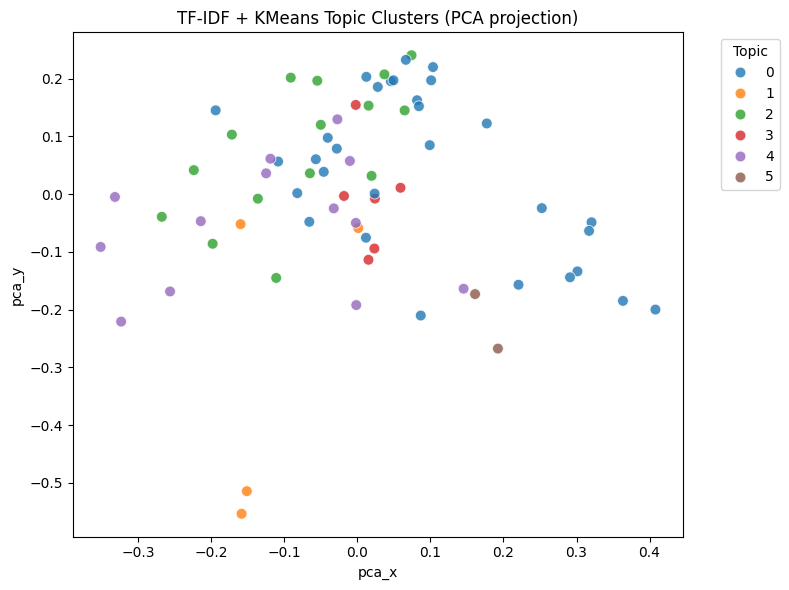


✅ Saved topic clusters to topic_model_tfidf.csv


In [ ]:
# ====================================================
# STEP C️⃣  Topic Grouping / Clustering
# ====================================================

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------
# 1) Load the dataset
# ----------------------------------------------------
df = pd.read_csv("extracted_entities_full.csv")

# Ensure text column exists
if "text" not in df.columns:
    df = df.rename(columns={df.columns[0]: "text"})

print(f"✅ Loaded {len(df)} abstracts for topic modeling")

# ----------------------------------------------------
# 2) Compute TF-IDF vectors
# ----------------------------------------------------
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=2000,
    ngram_range=(1, 2)
)
X = vectorizer.fit_transform(df["text"])

# ----------------------------------------------------
# 3) Run K-Means clustering
# ----------------------------------------------------
NUM_TOPICS = 6
kmeans = KMeans(n_clusters=NUM_TOPICS, random_state=42, n_init=10)
df["topic"] = kmeans.fit_predict(X)

print("✅ TF-IDF + KMeans topic modeling complete")

# ----------------------------------------------------
# 4) Display top keywords for each topic
# ----------------------------------------------------
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(NUM_TOPICS):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"\n🧩 Topic {i}: {', '.join(top_terms)}")
    examples = df[df["topic"] == i]["text"].head(2).tolist()
    for j, ex in enumerate(examples):
        print(f"   Example {j+1}: {ex[:180]}...")

# ----------------------------------------------------
# 5) 2-D visualization using PCA
# ----------------------------------------------------
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X.toarray())
df["pca_x"] = coords[:, 0]
df["pca_y"] = coords[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="pca_x",
    y="pca_y",
    hue="topic",
    palette="tab10",
    s=60,
    alpha=0.8
)
plt.title("TF-IDF + KMeans Topic Clusters (PCA projection)")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ----------------------------------------------------
# 6) Save topic results
# ----------------------------------------------------
df.to_csv("topic_model_tfidf.csv", index=False)
print("\n✅ Saved topic clusters to topic_model_tfidf.csv")

✅ Loaded 70 documents for BERTopic modeling
⚙️ Encoding sentences using SentenceTransformer...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2025-11-11 01:24:27,859 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-11 01:24:27,991 - BERTopic - Dimensionality - Completed ✓
2025-11-11 01:24:27,993 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-11 01:24:28,005 - BERTopic - Cluster - Completed ✓
2025-11-11 01:24:28,006 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.


🧠 Training BERTopic model...


2025-11-11 01:24:28,096 - BERTopic - Representation - Completed ✓
2025-11-11 01:24:28,098 - BERTopic - Topic reduction - Reducing number of topics
2025-11-11 01:24:28,109 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-11 01:24:28,215 - BERTopic - Representation - Completed ✓
2025-11-11 01:24:28,218 - BERTopic - Topic reduction - Reduced number of topics from 12 to 7
/tmp/ipython-input-904590104.py:122: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", max(1, len(uniq)))



📊 Topic Distribution:
topic_bertopic
 0    21
-1    17
 1     9
 2     9
 3     5
 4     5
 5     4
Name: count, dtype: int64

✅ Model discovered 7 valid topics

📚 Top 10 topics:
   Topic  Count                                    Name                                                                               Representation  \
0     -1     17                        -1_and_the_of_in                                      [and, the, of, in, ad, with, for, disease, genetic, to]   
1      0     21                         0_the_of_in_and                                    [the, of, in, and, with, ad, disease, to, for, alzheimer]   
2      1      9                        1_apoe_and_in_of                                            [apoe, and, in, of, the, ad, with, for, risk, or]   
3      2      9                    2_and_csf_levels_the                                           [and, csf, levels, the, in, of, ad, with, we, tau]   
4      3      5                     3_ad_and_the_ad and     

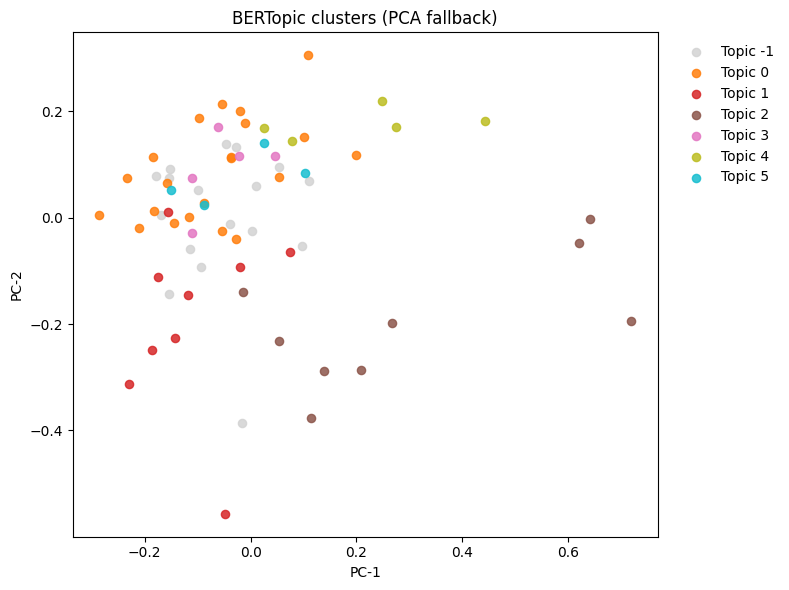

✅ Saved fallback plot: bertopic_pca_fallback.png

✅ Saved topic assignments to topic_model_bertopic.csv


In [ ]:
# ====================================================
# STEP C️⃣  Robust BERTopic for Biomedical Texts
# ====================================================

import pandas as pd
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

# ----------------------------------------------------
# 1️⃣ Load your processed entity extraction file
# ----------------------------------------------------
df = pd.read_csv("extracted_entities_full.csv")

# Combine text + extracted entities for better context
df["combined_text"] = (
    df["text"].fillna("") + " " +
    df["variants"].fillna("").astype(str) + " " +
    df["genes"].fillna("").astype(str) + " " +
    df["diseases"].fillna("").astype(str)
)
print(f"✅ Loaded {len(df)} documents for BERTopic modeling")

# ----------------------------------------------------
# 2️⃣ Generate semantic embeddings
# ----------------------------------------------------
print("⚙️ Encoding sentences using SentenceTransformer...")
model = SentenceTransformer("all-MiniLM-L6-v2")   # fast + accurate
embeddings = model.encode(df["combined_text"].tolist(), show_progress_bar=True)

# ----------------------------------------------------
# 3️⃣ Train BERTopic (tuned for small biomedical corpus)
# ----------------------------------------------------
print("🧠 Training BERTopic model...")
topic_model = BERTopic(
    language="english",
    n_gram_range=(1, 2),
    min_topic_size=2,               # smaller = more topics, fewer all -1
    calculate_probabilities=True,
    nr_topics='auto',
    verbose=True
)

topics, probs = topic_model.fit_transform(df["combined_text"].tolist(), embeddings)
df["topic_bertopic"] = topics

# ----------------------------------------------------
# 4️⃣ Summary statistics
# ----------------------------------------------------
topic_counts = df["topic_bertopic"].value_counts()
num_topics = (df["topic_bertopic"] >= 0).sum()
print("\n📊 Topic Distribution:")
print(topic_counts)
print(f"\n✅ Model discovered {len(topic_counts) - ('-1' in topic_counts)} valid topics")

# ----------------------------------------------------
# 5️⃣ Display sample topics
# ----------------------------------------------------
info = topic_model.get_topic_info()
print("\n📚 Top 10 topics:")
print(info.head(10))

for t in info["Topic"].head(5):
    if t == -1:
        continue  # skip outlier cluster
    print(f"\n=== Topic {t} ===")
    print("Keywords:", [w for w, _ in topic_model.get_topic(t)])
    examples = df.loc[df["topic_bertopic"] == t, "text"].head(2)
    for j, ex in enumerate(examples):
        print(f"Example {j+1}:\n{ex[:300]}...\n")

# ----------------------------------------------------
# 6️⃣ Visualization (inline + files + robust fallback)
# ----------------------------------------------------
print("📈 Generating topic visualization (inline + save to files)...")

try:
    # --- Plotly interactive topic map (preferred) ---
    # Pass embeddings explicitly to avoid IndexError in some environments
    fig = topic_model.visualize_topics(embeddings=embeddings)

    # Show inline in the notebook
    fig.show()

    # Save interactive HTML
    fig.write_html("bertopic_topics.html")

    # Save a static PNG (best effort; requires 'kaleido')
    try:
        import kaleido  # noqa: F401  # check availability
        fig.write_image("bertopic_topics.png", scale=2)
        print("✅ Saved static PNG: bertopic_topics.png")
    except Exception as _:
        print("ℹ️ 'kaleido' not available; skipped PNG export for topic map")

    # --- Top keywords bar chart (interactive) ---
    bar = topic_model.visualize_barchart(top_n_topics=10)
    bar.show()
    bar.write_html("bertopic_barchart.html")
    try:
        import kaleido  # noqa: F401
        bar.write_image("bertopic_barchart.png", scale=2)
        print("✅ Saved static PNG: bertopic_barchart.png")
    except Exception as _:
        print("ℹ️ 'kaleido' not available; skipped PNG export for barchart")

    print("✅ Visualizations saved: bertopic_topics.html, bertopic_barchart.html")

except Exception as e:
    # --- Robust fallback: PCA + Matplotlib scatter ---
    print(f"⚠️ Plotly visualization failed, falling back to PCA: {e}")
    from sklearn.decomposition import PCA
    import numpy as np
    import matplotlib.pyplot as plt

    # Reduce to 2D with PCA
    coords = PCA(n_components=2, random_state=42).fit_transform(embeddings)
    labels = df["topic_bertopic"].to_numpy()
    uniq = np.unique(labels)

    # Draw scatter, gray for outliers (-1), color for valid topics
    plt.figure(figsize=(8, 6))
    cmap = plt.cm.get_cmap("tab10", max(1, len(uniq)))
    for i, t in enumerate(sorted(uniq)):
        mask = labels == t
        color = "lightgray" if t == -1 else cmap(i % 10)
        plt.scatter(
            coords[mask, 0], coords[mask, 1],
            s=35, alpha=0.85, label=f"Topic {t}", c=[color]
        )

    plt.title("BERTopic clusters (PCA fallback)")
    plt.xlabel("PC-1")
    plt.ylabel("PC-2")
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
    plt.tight_layout()
    plt.savefig("bertopic_pca_fallback.png", dpi=200)
    plt.show()
    print("✅ Saved fallback plot: bertopic_pca_fallback.png")

# ----------------------------------------------------
# 7️⃣ Save results
# ----------------------------------------------------
df.to_csv("topic_model_bertopic.csv", index=False)
print("\n✅ Saved topic assignments to topic_model_bertopic.csv")

# Bonus

In [ ]:
# Hybrid NER: scispaCy/spaCy + regex
import re, pandas as pd
import spacy
from spacy.matcher import Matcher

# 1) Load a model (use scispaCy if available, else fallback to spaCy small)
try:
    nlp = spacy.load("en_core_sci_sm")
except:
    nlp = spacy.load("en_core_web_sm")

# 2) Regex/rule helpers
VARIANT_RE = re.compile(r"(?i)\brs\d+\b")
GENE_TOKEN_RE = re.compile(r"\b[A-Z0-9]{2,7}\b")   # simple upper-case gene-like
ABBREV_MAP = {
    "AD": "Alzheimer Disease",
    "LOAD": "Late-Onset Alzheimer Disease",
    "CSF": "Cerebrospinal Fluid"
}
GENE_STOP = {"DNA","RNA","GWAS","SNP","CNV","CI","OR","HR","MRI","ABETA","TAU","AP"}  # prune common FP UPPER

def normalize_gene(g):
    g = g.upper()
    return None if (len(g) < 2 or g in GENE_STOP) else g

def expand_abbrev(s):
    # Expand common biomedical abbreviations in a text span
    for short,long in ABBREV_MAP.items():
        s = re.sub(rf"\b{short}\b", long, s)
    return s

def hybrid_ner(text: str):
    """Return dict: variants, genes, diseases (hybrid from ML + rules)."""
    doc = nlp(text)

    # ML NER hits (keep disease-like labels; models differ in tagsets)
    disease_like = []
    for ent in doc.ents:
        if ent.label_.lower() in {"disease","disorder","phenotype","condition"} or "disease" in ent.text.lower():
            disease_like.append(ent.text)

    # Regex/rule hits
    variants = set(VARIANT_RE.findall(text))
    genes_rule = {normalize_gene(t) for t in GENE_TOKEN_RE.findall(text)}
    genes = sorted({g for g in genes_rule if g})

    # Normalize diseases (expand common abbreviations)
    diseases = sorted({expand_abbrev(x).strip() for x in disease_like})

    return {"variants": sorted(variants), "genes": genes, "diseases": diseases}

# Example: apply hybrid NER to your dataframe (df with 'text')
# df[["variants_h","genes_h","diseases_h"]] = df["text"].apply(lambda s: pd.Series(hybrid_ner(s)))

In [ ]:
# Dependency patterns to link Variant ↔ Gene ↔ Disease
import spacy
from spacy.matcher import DependencyMatcher

try:
    nlp = spacy.load("en_core_sci_sm")
except:
    nlp = spacy.load("en_core_web_sm")

dep = DependencyMatcher(nlp.vocab)

# Pattern: "[VARIANT] in [GENE] increases [DISEASE] risk"
pattern_increases = [
  {"RIGHT_ID": "var", "RIGHT_ATTRS": {"LOWER": {"REGEX": r"rs\d+"}}},
  {"LEFT_ID": "var", "REL_OP": ">>", "RIGHT_ID": "in", "RIGHT_ATTRS": {"LOWER": "in"}},
  {"LEFT_ID": "in", "REL_OP": ">", "RIGHT_ID": "gene", "RIGHT_ATTRS": {"IS_ALPHA": True, "IS_UPPER": True}},
  {"LEFT_ID": "gene", "REL_OP": ">>", "RIGHT_ID": "verb", "RIGHT_ATTRS": {"LEMMA": {"IN": ["increase","associate","affect"]}}},
  {"LEFT_ID": "verb", "REL_OP": ">>", "RIGHT_ID": "disease", "RIGHT_ATTRS": {"LOWER": {"REGEX": r"[a-z]+(?:['-]s)?(?:\s+[a-z]+)+"}}}
]
dep.add("VAR_GENE_DISEASE_INCREASE", [pattern_increases])

REL_LEMMAS = {"associate":"associated with","increase":"increases risk of","affect":"affects"}

def extract_relations_dep(text):
    doc = nlp(text)
    rels = []
    for match_id, token_ids in dep(doc):
        t = {doc[i].lower_: doc[i] for i in token_ids}
        var = next((doc[i] for i in token_ids if doc[i].lower_.startswith("rs")), None)
        gene = next((doc[i] for i in token_ids if doc[i].is_alpha and doc[i].text.isupper()), None)
        verb = next((doc[i] for i in token_ids if doc[i].lemma_ in REL_LEMMAS), None)
        disease = next((doc[i] for i in token_ids if i in token_ids and doc[i].is_alpha and not doc[i].text.isupper()), None)
        if var and gene and verb and disease:
            span = doc[min(token_ids): max(token_ids)+1].text
            rels.append({
                "variant": var.text,
                "gene": gene.text,
                "phenotype": disease.text,
                "relation": REL_LEMMAS.get(verb.lemma_, verb.text),
                "evidence_span": span
            })
    return rels

# Usage:
# df["dep_rels"] = df["text"].apply(extract_relations_dep)

In [ ]:
# Lightweight normalization helpers
import re

COMMON_GENE_FIX = {"ApoE":"APOE", "Apoe":"APOE"}
COMMON_DISEASE_CASE = {"alzheimer’s disease":"Alzheimer Disease", "alzheimer disease":"Alzheimer Disease"}

def normalize_entities(variants, genes, diseases):
    # Variants → lowercase 'rs' + digits canonical
    v2 = sorted({re.sub(r"^RS", "rs", v).lower() for v in variants})

    # Genes → uppercase, fix common variants, drop obvious non-genes
    g2 = []
    for g in genes:
        g = COMMON_GENE_FIX.get(g, g)
        g = g.upper()
        if 2 <= len(g) <= 12 and g.isalnum():
            g2.append(g)
    g2 = sorted(set(g2))

    # Diseases → title/standardize common names, expand abbreviations
    d2 = []
    for d in diseases:
        dd = d.strip().lower()
        dd = COMMON_DISEASE_CASE.get(dd, dd.title())
        d2.append(dd)
    d2 = sorted(set(d2))
    return v2, g2, d2

# Example:
# out_df[["variants_n","genes_n","diseases_n"]] = out_df.apply(
#     lambda r: pd.Series(normalize_entities(r["variants"], r["genes"], r["diseases"])), axis=1)

In [ ]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

df = pd.read_csv("curated_results.csv")

gene_w = widgets.Text(description="Gene", placeholder="substring")
variant_w = widgets.Text(description="Variant", placeholder="substring")
disease_w = widgets.Text(description="Phenotype", placeholder="substring")
rel_opts = ["(All)"] + sorted(df["relation"].dropna().unique().tolist())
relation_w = widgets.Dropdown(options=rel_opts, description="Relation")
out = widgets.Output()

def refresh(_=None):
    with out:
        clear_output()
        mask = pd.Series(True, index=df.index)
        if gene_w.value:
            mask &= df["gene"].fillna("").str.contains(gene_w.value, case=False)
        if variant_w.value:
            mask &= df["variant"].fillna("").str.contains(variant_w.value, case=False)
        if disease_w.value:
            mask &= df["phenotype"].fillna("").str.contains(disease_w.value, case=False)
        if relation_w.value != "(All)":
            mask &= df["relation"].fillna("") == relation_w.value
        display(df[mask].reset_index(drop=True))

for w in [gene_w, variant_w, disease_w, relation_w]:
    w.observe(refresh, names="value")

display(widgets.HBox([gene_w, variant_w, disease_w, relation_w]))
display(out)
refresh()

Output()

In [ ]:
import pandas as pd
import re

rel = pd.read_csv("curated_results.csv")          # predicted relations
ents = pd.read_csv("extracted_entities_full.csv") # entity table

# Heuristics to spot likely false positives
def suspicious_row(r):
    bad_gene = (not isinstance(r["gene"], str)) or len(r["gene"]) < 2 or r["gene"] in {"DNA","RNA","GWAS","SNP"}
    bad_rel = not r["relation"]
    bad_span = len(str(r["evidence_span"])) < 20
    return bad_gene or bad_rel or bad_span

fps = rel[rel.apply(suspicious_row, axis=1)].head(5)
print("\n⚠️ Likely false positives (top 5):")
print(fps[["text_id","variant","gene","phenotype","relation","evidence_span"]].to_string(index=False))

# Potential false negatives: texts that mention rs-IDs but no relation captured
has_rs = ents["text"].str.contains(r"\brs\d+\b", case=False, regex=True)
has_rel = ents["text"].str.contains(r"associated with|increases risk of|affects|linked to", case=False, regex=True)
fns_idx = ents[has_rs & (~has_rel)].head(5).index
print("\n❓ Potential false negatives (texts with rs-ID but no relation phrase):", list(fns_idx))
for i in fns_idx:
    print(f"\n— T{i:04d} —")
    print(ents.loc[i, "text"][:300], "...")


⚠️ Likely false positives (top 5):
text_id variant gene                  phenotype        relation                                                                                                            evidence_span
  T0000     NaN  DNA The International Genomics associated with iated with AD are located on non-coding DNA regions, and their functional impacts on AD are as yet poorly understood. We
  T0000     NaN  SNP The International Genomics associated with med 19 single-nucleotide polymorphisms (SNPs) associated with AD are located on non-coding DNA regions, and their functi
  T0001     NaN GWAS                        NaN associated with evious genome-wide association studies (GWAS). Also, four of them were located within two chromosomal regions (i.e., 3q1
  T0003     NaN GWAS                        NaN             NaN ed in a recent genome-wide association (GWAS)-by-familial-proxy of Alzheimer's or dementia. Fine-mapping of the human le
  T0006     NaN GWAS                   